# Homework 06

## Assignment 2 CIFAR-10 Classification Again

In [2]:
# general imports
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt
import datetime
import tqdm

# magic line only needed in jupyter notebooks!
%reload_ext tensorboard

2022-12-10 19:40:42.034348: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-10 19:40:42.132174: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### 2.1 Prepare dataset

* information about the data
    * dataset size: 60 000 images (50 000 train, 10 000 test) 
    * classes: 10 classes (each has 6000 images - that means an even distribution of classes which is important for the informative value of e.g. accuracy scores); given in int64 
        * classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck	(4 inanimates, 6 animates)									
        * classes are completely mutually exclusive; e.g. there is no overlap between automobiles and trucks 
    * type of data: 32x32 colour images 
    * image size: shape=(32, 32, 3), dtype=uint8
    * color channels: 3 
 
* load data and visualize

In [3]:
# loading data
(train_ds, test_ds), ds_info = tfds.load('cifar10', split =['train', 'test'],
                                               as_supervised =True , with_info = True )

2022-12-10 18:12:18.773196: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


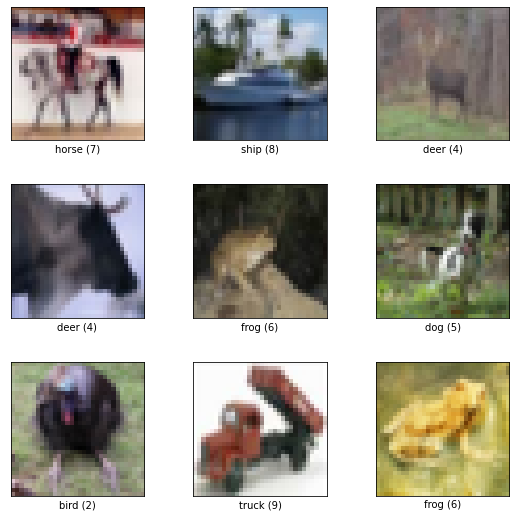

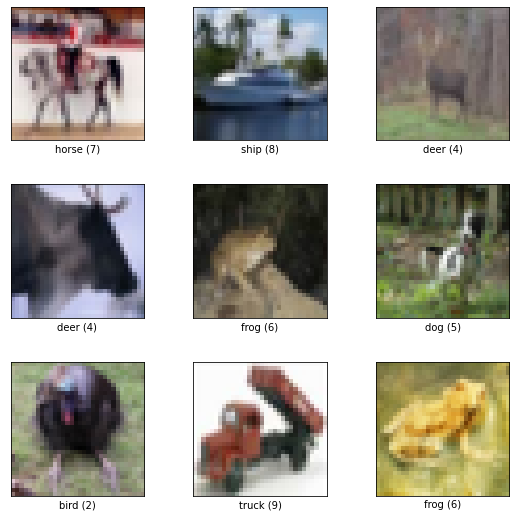

In [4]:
# some examples of images in dataset
tfds.show_examples(train_ds, ds_info)

### 2.1

* data augmentation -> here: random rotation of images
* preprocess loaded data

In [5]:
# data augmentation: rotation of images 
data_augmentation = tf.keras.Sequential([layers.RandomFlip("horizontal_and_vertical"),layers.RandomRotation(0.2),])


In [6]:
# preprocessing
def preprocess_data(cifar, train_flag, augment):
    # augment data by randomly rotating images
    if augment:
        cifar = cifar.map(lambda img, target: (data_augmentation(img, training=train_flag), target))
    # convert data from uint8 to float32
    cifar = cifar.map(lambda img, target: (tf.cast(img, tf.float32), target))
    # input normalization, bringing image values from range [0, 255] to [-1, 1]
    cifar = cifar.map(lambda img, target: (tf.cast(tf.image.per_image_standardization(img), tf.float32), target))
    # target vectors (one-hot encoding) for 10 classes
    cifar = cifar.map(lambda img, target: (img, tf.one_hot(target, depth=10)))
                      
    # cache this progress in memory, as there is no need to redo it; it is deterministic after all
    cifar = cifar.cache()
    # shuffle, batch, prefetch
    cifar = cifar.shuffle(1000)
    cifar = cifar.batch(32)
    cifar = cifar.prefetch(20)
    
    # return preprocessed dataset
    return cifar

In [7]:
# Preprocess data with data-augmentation
augmented_train_dataset = preprocess_data(train_ds, train_flag=True, augment=True)
augmented_test_dataset = preprocess_data(test_ds, train_flag=False, augment=True)

# Preprocess data without data-augmentation
train_dataset = preprocess_data(train_ds, train_flag=False, augment=False)
test_dataset = preprocess_data(test_ds, train_flag=False, augment=False)

In [8]:
# visualize how the pre-processed data looks like
# Tensor with shape (batch-size, height, width, channels) for images 
# here: (32, 32, 32, 3)
# and Tensor with shape (batch-size, num_classes) for targets
# here: (32, 10)
iterator = iter(train_dataset)
iterator.get_next()

(<tf.Tensor: shape=(32, 32, 32, 3), dtype=float32, numpy=
 array([[[[ 9.17724729e-01,  9.17724729e-01,  9.17724729e-01],
          [ 8.32218587e-01,  7.46712506e-01,  6.04202330e-01],
          [ 4.90194231e-01,  3.76186073e-01,  1.48169816e-01],
          ...,
          [ 1.34525526e+00,  1.48776543e+00,  1.60177350e+00],
          [ 1.20274508e+00,  1.34525526e+00,  1.51626742e+00],
          [ 6.32704377e-01,  7.75214553e-01,  1.00323081e+00]],
 
         [[ 1.20274508e+00,  1.23124707e+00,  1.37375724e+00],
          [ 1.11723900e+00,  1.11723900e+00,  1.08873689e+00],
          [ 7.75214553e-01,  6.89708471e-01,  5.18696249e-01],
          ...,
          [ 1.43076134e+00,  1.54476941e+00,  1.63027549e+00],
          [ 1.14574099e+00,  1.25974905e+00,  1.31675315e+00],
          [ 8.89222682e-01,  1.00323081e+00,  1.11723900e+00]],
 
         [[ 1.77278566e+00,  1.85829175e+00,  1.88679385e+00],
          [ 1.65877759e+00,  1.68727958e+00,  1.60177350e+00],
          [ 1.25974905e+

### 2.2 Optimze your model  

* basic architecture
    * does our model overfit the data? yes, the training loss of the model becomes zero after a few epochs but testing loss and accuracies remain around a suboptimal level showing clearly that the model cannot generalize to unseen data but just perfectly memorized the trainig data (why is training accuracy still bad though?)
* 5 things to optimze (see models.py file for code implementations and optimizations.Rmd for detailed descriptions)
    * batch normalization
    * dropout
    * regularization L2
    * Glorot Normal init instead of Uniform 
    * Try all Models with data augmentation 

### 2.3 Training the network and 2.4 Visualization 

In [9]:
def training_loop(model, train_ds, test_ds, epochs, train_summary_writer, test_summary_writer):

    # iterate over epochs
    for e in range(epochs):

        # train steps on all batches in the training data
        for data in tqdm.tqdm(train_ds, position=0, leave=True):
            metrics = model.train_step(data)

        # log and print training metrics
        with train_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
        
        #print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        # 4. reset metric objects
        model.reset_metrics()


        # 5. evaluate on validation data
        for data in test_ds:
            metrics = model.test_step(data)
        
        # log validation metrics
        with test_summary_writer.as_default():
            # for scalar metrics:
            for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=e)
            # alternatively, log metrics individually (allows for non-scalar metrics such as tf.keras.metrics.MeanTensor)
            # e.g. tf.summary.image(name="mean_activation_layer3", data = metrics["mean_activation_layer3"],step=e)
            
        print([f"test_{key}: {value.numpy()}" for (key, value) in metrics.items()])
        # 7. reset metric objects
        model.reset_metrics()

In [10]:
def create_summary_writers(config_name):
    
    # Define where to save the logs
    # along with this, you may want to save a config file with the same name so you know what the hyperparameters were used
    # alternatively make a copy of the code that is used for later reference
    
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

    train_log_path = f"logs/{config_name}/{current_time}/train"
    test_log_path = f"logs/{config_name}/{current_time}/test"

    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)

    # log writer for test metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
    return train_summary_writer, test_summary_writer

In [11]:
# try out models with different optimization techniques
from models import CNN, CNN_batchnorm, CNN_dropout, CNN_L2loss, CNN_GlorotNormal 

# initialize models
models = [[CNN(), "run_basic"], 
          [CNN_batchnorm(), "run_batchnorm"], 
          [CNN_dropout(), "run_dropout"], 
          [CNN_L2loss(), "run_L2loss"], 
          [CNN_GlorotNormal(), "run_GlorotNormal"]]


# run training loop 
for model in models:
    print(model[1])
    train_summary_writer, test_summary_writer = create_summary_writers(model[1])
    augmented_train_summary_writer, augmented_test_summary_writer = create_summary_writers(f"augmented_{model[1]}")
    training_loop(model=model[0], 
                  train_ds=train_dataset, 
                  test_ds=test_dataset, 
                  epochs= 15, 
                  train_summary_writer=train_summary_writer, 
                  test_summary_writer=test_summary_writer)
    training_loop(model=model[0], 
                  train_ds=augmented_train_dataset, 
                  test_ds=augmented_test_dataset, 
                  epochs= 15, 
                  train_summary_writer=augmented_train_summary_writer, 
                  test_summary_writer=augmented_test_summary_writer)

run_basic


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 63.78it/s]


['loss: 1.6752797365188599', 'acc: 0.3774999976158142']
['test_loss: 1.4458528757095337', 'test_acc: 0.4763000011444092']


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.71it/s]


['loss: 1.3218871355056763', 'acc: 0.5255399942398071']
['test_loss: 1.2048753499984741', 'test_acc: 0.5723999738693237']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.63it/s]


['loss: 1.1630830764770508', 'acc: 0.5875200033187866']
['test_loss: 1.1241177320480347', 'test_acc: 0.6062999963760376']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.88it/s]


['loss: 1.067677617073059', 'acc: 0.6216800212860107']
['test_loss: 1.0361299514770508', 'test_acc: 0.6261000037193298']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.55it/s]


['loss: 0.9983634352684021', 'acc: 0.6494600176811218']
['test_loss: 0.9755072593688965', 'test_acc: 0.6564000248908997']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.68it/s]


['loss: 0.9404948353767395', 'acc: 0.6689199805259705']
['test_loss: 0.9329798817634583', 'test_acc: 0.6678000092506409']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 69.11it/s]


['loss: 0.8969346880912781', 'acc: 0.6843799948692322']
['test_loss: 0.9226195812225342', 'test_acc: 0.6739000082015991']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 69.12it/s]


['loss: 0.8585870265960693', 'acc: 0.6963000297546387']
['test_loss: 0.8557860255241394', 'test_acc: 0.6965000033378601']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 69.18it/s]


['loss: 0.8262139558792114', 'acc: 0.7114199995994568']
['test_loss: 0.8446668982505798', 'test_acc: 0.6970000267028809']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 66.55it/s]


['loss: 0.7936622500419617', 'acc: 0.7217400074005127']
['test_loss: 0.8240855932235718', 'test_acc: 0.7113000154495239']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.25it/s]


['loss: 0.7612685561180115', 'acc: 0.7329999804496765']
['test_loss: 0.8345761299133301', 'test_acc: 0.7053999900817871']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.08it/s]


['loss: 0.7403441071510315', 'acc: 0.7412400245666504']
['test_loss: 0.8170960545539856', 'test_acc: 0.713699996471405']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.25it/s]


['loss: 0.7184759378433228', 'acc: 0.7480400204658508']
['test_loss: 0.8005867600440979', 'test_acc: 0.7210999727249146']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.00it/s]


['loss: 0.6945722103118896', 'acc: 0.7570000290870667']
['test_loss: 0.7613503932952881', 'test_acc: 0.7386000156402588']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 66.74it/s]


['loss: 0.6756344437599182', 'acc: 0.7644199728965759']
['test_loss: 0.7650131583213806', 'test_acc: 0.7365999817848206']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.61it/s]


['loss: 1.2297159433364868', 'acc: 0.5646600127220154']
['test_loss: 0.9500415325164795', 'test_acc: 0.6723999977111816']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 65.41it/s]


['loss: 1.1348413228988647', 'acc: 0.5977799892425537']
['test_loss: 1.0168102979660034', 'test_acc: 0.6572999954223633']


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 63.12it/s]


['loss: 1.087345838546753', 'acc: 0.614080011844635']
['test_loss: 1.0201534032821655', 'test_acc: 0.6585999727249146']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.39it/s]


['loss: 1.0503121614456177', 'acc: 0.6274600028991699']
['test_loss: 0.9794240593910217', 'test_acc: 0.6715999841690063']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 56.31it/s]


['loss: 1.0163731575012207', 'acc: 0.6393399834632874']
['test_loss: 1.0386059284210205', 'test_acc: 0.6572999954223633']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.48it/s]


['loss: 0.9926847815513611', 'acc: 0.6491199731826782']
['test_loss: 0.9985145926475525', 'test_acc: 0.6682999730110168']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.15it/s]


['loss: 0.9675247669219971', 'acc: 0.6567000150680542']
['test_loss: 0.8842839002609253', 'test_acc: 0.6960999965667725']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.69it/s]


['loss: 0.9484875202178955', 'acc: 0.662339985370636']
['test_loss: 1.0404092073440552', 'test_acc: 0.6685000061988831']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.30it/s]


['loss: 0.9242414236068726', 'acc: 0.6727399826049805']
['test_loss: 0.9395081400871277', 'test_acc: 0.6786999702453613']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.35it/s]


['loss: 0.908240795135498', 'acc: 0.677299976348877']
['test_loss: 1.0462191104888916', 'test_acc: 0.6704999804496765']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.46it/s]


['loss: 0.8919325470924377', 'acc: 0.6837000250816345']
['test_loss: 1.0580366849899292', 'test_acc: 0.6657000184059143']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 57.04it/s]


['loss: 0.8727604746818542', 'acc: 0.691540002822876']
['test_loss: 0.89947110414505', 'test_acc: 0.6947000026702881']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.24it/s]


['loss: 0.8592607378959656', 'acc: 0.6970599889755249']
['test_loss: 0.9052246809005737', 'test_acc: 0.7009000182151794']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.37it/s]


['loss: 0.8446298241615295', 'acc: 0.7001799941062927']
['test_loss: 1.0305508375167847', 'test_acc: 0.66839998960495']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.72it/s]


['loss: 0.8316630721092224', 'acc: 0.7076799869537354']
['test_loss: 1.0062960386276245', 'test_acc: 0.6718000173568726']
run_batchnorm


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 58.40it/s]


['loss: 1.3582292795181274', 'acc: 0.516260027885437']
['test_loss: 1.137848973274231', 'test_acc: 0.597100019454956']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.79it/s]


['loss: 1.0313453674316406', 'acc: 0.6398400068283081']
['test_loss: 0.9608094096183777', 'test_acc: 0.6607999801635742']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.98it/s]


['loss: 0.8958050012588501', 'acc: 0.686959981918335']
['test_loss: 0.8934496641159058', 'test_acc: 0.6859999895095825']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.29it/s]


['loss: 0.8168892860412598', 'acc: 0.7170400023460388']
['test_loss: 0.8380240201950073', 'test_acc: 0.708899974822998']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.68it/s]


['loss: 0.7582207918167114', 'acc: 0.7364000082015991']
['test_loss: 0.8065122961997986', 'test_acc: 0.7218000292778015']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 57.18it/s]


['loss: 0.7141724228858948', 'acc: 0.7511000037193298']
['test_loss: 0.7798472046852112', 'test_acc: 0.7348999977111816']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.02it/s]


['loss: 0.6810699701309204', 'acc: 0.7636600136756897']
['test_loss: 0.7505062222480774', 'test_acc: 0.7418000102043152']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 58.70it/s]


['loss: 0.6419743895530701', 'acc: 0.7773399949073792']
['test_loss: 0.7624467611312866', 'test_acc: 0.7401999831199646']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 56.63it/s]


['loss: 0.6176616549491882', 'acc: 0.7857199907302856']
['test_loss: 0.7616624236106873', 'test_acc: 0.7390000224113464']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 58.78it/s]


['loss: 0.5952828526496887', 'acc: 0.7941200137138367']
['test_loss: 0.7347660660743713', 'test_acc: 0.7526999711990356']


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.74it/s]


['loss: 0.5741080641746521', 'acc: 0.7996600270271301']
['test_loss: 0.7557018995285034', 'test_acc: 0.7483000159263611']


100%|███████████████████████████████████████| 1563/1563 [00:26<00:00, 59.90it/s]


['loss: 0.5536553263664246', 'acc: 0.8078200221061707']
['test_loss: 0.748691737651825', 'test_acc: 0.7516000270843506']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.98it/s]


['loss: 0.5340266227722168', 'acc: 0.8145400285720825']
['test_loss: 0.7430965304374695', 'test_acc: 0.7544000148773193']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.85it/s]


['loss: 0.519163966178894', 'acc: 0.8195800185203552']
['test_loss: 0.7408339977264404', 'test_acc: 0.7573000192642212']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.26it/s]


['loss: 0.5047601461410522', 'acc: 0.8235800266265869']
['test_loss: 0.7287232279777527', 'test_acc: 0.7601000070571899']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.39it/s]


['loss: 1.243259310722351', 'acc: 0.5705400109291077']
['test_loss: 0.8883503079414368', 'test_acc: 0.6920999884605408']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.66it/s]


['loss: 1.0926653146743774', 'acc: 0.6161400079727173']
['test_loss: 0.8780167698860168', 'test_acc: 0.6966000199317932']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.60it/s]


['loss: 1.036375641822815', 'acc: 0.6365399956703186']
['test_loss: 0.8992102146148682', 'test_acc: 0.6904000043869019']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.46it/s]


['loss: 0.9948770999908447', 'acc: 0.6523600220680237']
['test_loss: 0.8845306634902954', 'test_acc: 0.6940000057220459']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.39it/s]


['loss: 0.9630579352378845', 'acc: 0.6605799794197083']
['test_loss: 0.9091361165046692', 'test_acc: 0.6845999956130981']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.85it/s]


['loss: 0.9378038048744202', 'acc: 0.6719800233840942']
['test_loss: 0.8905723690986633', 'test_acc: 0.6901999711990356']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.19it/s]


['loss: 0.9133986234664917', 'acc: 0.6786999702453613']
['test_loss: 0.8961759805679321', 'test_acc: 0.6912999749183655']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.54it/s]


['loss: 0.8894757032394409', 'acc: 0.6867799758911133']
['test_loss: 0.8906589150428772', 'test_acc: 0.6937000155448914']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 61.34it/s]


['loss: 0.8682546615600586', 'acc: 0.6938400268554688']
['test_loss: 0.9196634888648987', 'test_acc: 0.6866000294685364']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.21it/s]


['loss: 0.8502136468887329', 'acc: 0.7027000188827515']
['test_loss: 0.9261147975921631', 'test_acc: 0.6822999715805054']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 62.03it/s]


['loss: 0.8294247984886169', 'acc: 0.7084000110626221']
['test_loss: 0.9099146723747253', 'test_acc: 0.6894999742507935']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.98it/s]


['loss: 0.814801812171936', 'acc: 0.7148600220680237']
['test_loss: 0.9314648509025574', 'test_acc: 0.6820999979972839']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 62.26it/s]


['loss: 0.7969019412994385', 'acc: 0.7193800210952759']
['test_loss: 0.9359627366065979', 'test_acc: 0.682200014591217']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 62.22it/s]


['loss: 0.7844534516334534', 'acc: 0.7224799990653992']
['test_loss: 0.9301555752754211', 'test_acc: 0.6841999888420105']


100%|███████████████████████████████████████| 1563/1563 [00:25<00:00, 60.69it/s]


['loss: 0.7675769329071045', 'acc: 0.7288200259208679']
['test_loss: 0.9481093883514404', 'test_acc: 0.6822999715805054']
run_dropout


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 47.40it/s]


['loss: 1.7064836025238037', 'acc: 0.36594000458717346']
['test_loss: 1.4263771772384644', 'test_acc: 0.48660001158714294']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


['loss: 1.319461703300476', 'acc: 0.5289400219917297']
['test_loss: 1.2589515447616577', 'test_acc: 0.5543000102043152']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 48.52it/s]


['loss: 1.169203519821167', 'acc: 0.583899974822998']
['test_loss: 1.1640567779541016', 'test_acc: 0.573199987411499']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.16it/s]


['loss: 1.0805978775024414', 'acc: 0.6180599927902222']
['test_loss: 1.0460234880447388', 'test_acc: 0.6305999755859375']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 48.86it/s]


['loss: 1.017347812652588', 'acc: 0.6398599743843079']
['test_loss: 1.0052541494369507', 'test_acc: 0.6399999856948853']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.43it/s]


['loss: 0.9619476199150085', 'acc: 0.6601799726486206']
['test_loss: 0.9756481647491455', 'test_acc: 0.6514000296592712']


100%|███████████████████████████████████████| 1563/1563 [00:33<00:00, 46.20it/s]


['loss: 0.9239007830619812', 'acc: 0.6774200201034546']
['test_loss: 0.968385636806488', 'test_acc: 0.6516000032424927']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 48.08it/s]


['loss: 0.8807231783866882', 'acc: 0.6911200284957886']
['test_loss: 0.9217133522033691', 'test_acc: 0.6775000095367432']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 48.58it/s]


['loss: 0.852398693561554', 'acc: 0.7015600204467773']
['test_loss: 0.8949094414710999', 'test_acc: 0.6863999962806702']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 48.98it/s]


['loss: 0.82297682762146', 'acc: 0.7122399806976318']
['test_loss: 0.8975605964660645', 'test_acc: 0.6855000257492065']


100%|███████████████████████████████████████| 1563/1563 [00:30<00:00, 51.33it/s]


['loss: 0.7972115278244019', 'acc: 0.7200999855995178']
['test_loss: 0.8436654806137085', 'test_acc: 0.7050999999046326']


100%|███████████████████████████████████████| 1563/1563 [00:29<00:00, 53.29it/s]


['loss: 0.7749201655387878', 'acc: 0.7293400168418884']
['test_loss: 0.8141117691993713', 'test_acc: 0.7134000062942505']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.08it/s]


['loss: 0.7557076811790466', 'acc: 0.737060010433197']
['test_loss: 0.833722710609436', 'test_acc: 0.7143999934196472']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.11it/s]


['loss: 0.7351524829864502', 'acc: 0.7425600290298462']
['test_loss: 0.8013898730278015', 'test_acc: 0.7185999751091003']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.47it/s]


['loss: 0.7235012650489807', 'acc: 0.7480000257492065']
['test_loss: 0.7656391859054565', 'test_acc: 0.7354999780654907']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 47.96it/s]


['loss: 1.2713814973831177', 'acc: 0.5528799891471863']
['test_loss: 1.000982642173767', 'test_acc: 0.651199996471405']


100%|███████████████████████████████████████| 1563/1563 [00:32<00:00, 48.79it/s]


['loss: 1.179210901260376', 'acc: 0.5828400254249573']
['test_loss: 0.9491414427757263', 'test_acc: 0.6690000295639038']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.72it/s]


['loss: 1.1333990097045898', 'acc: 0.6003599762916565']
['test_loss: 0.9978629946708679', 'test_acc: 0.6536999940872192']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.39it/s]


['loss: 1.10245943069458', 'acc: 0.6107400059700012']
['test_loss: 0.9498295783996582', 'test_acc: 0.6729000210762024']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.61it/s]


['loss: 1.0743128061294556', 'acc: 0.6234599947929382']
['test_loss: 0.9881068468093872', 'test_acc: 0.6621999740600586']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.74it/s]


['loss: 1.052306890487671', 'acc: 0.6294000148773193']
['test_loss: 0.9793543219566345', 'test_acc: 0.6676999926567078']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 50.17it/s]


['loss: 1.0354324579238892', 'acc: 0.6356800198554993']
['test_loss: 1.0139398574829102', 'test_acc: 0.6599000096321106']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.80it/s]


['loss: 1.0184295177459717', 'acc: 0.6401200294494629']
['test_loss: 0.9655576348304749', 'test_acc: 0.6746000051498413']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.18it/s]


['loss: 0.9974240064620972', 'acc: 0.6483200192451477']
['test_loss: 1.047134518623352', 'test_acc: 0.6524999737739563']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.61it/s]


['loss: 0.9857262372970581', 'acc: 0.6541200280189514']
['test_loss: 1.0124635696411133', 'test_acc: 0.6621999740600586']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.98it/s]


['loss: 0.9766288995742798', 'acc: 0.6564800143241882']
['test_loss: 0.9872210025787354', 'test_acc: 0.6693000197410583']


100%|███████████████████████████████████████| 1563/1563 [00:31<00:00, 49.64it/s]


['loss: 0.9640668630599976', 'acc: 0.6622200012207031']
['test_loss: 0.9871843457221985', 'test_acc: 0.6697999835014343']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 55.97it/s]


['loss: 0.949203610420227', 'acc: 0.6669999957084656']
['test_loss: 1.0090559720993042', 'test_acc: 0.6608999967575073']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 56.01it/s]


['loss: 0.9413247108459473', 'acc: 0.6703600287437439']
['test_loss: 0.9599120020866394', 'test_acc: 0.6854000091552734']


100%|███████████████████████████████████████| 1563/1563 [00:27<00:00, 56.12it/s]


['loss: 0.9339525699615479', 'acc: 0.6724600195884705']
['test_loss: 0.9574299454689026', 'test_acc: 0.679099977016449']
run_L2loss


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.59it/s]


['loss: 1.7409321069717407', 'acc: 0.3758600056171417']
['test_loss: 1.4807285070419312', 'test_acc: 0.47380000352859497']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.03it/s]


['loss: 1.3738758563995361', 'acc: 0.5195599794387817']
['test_loss: 1.2707096338272095', 'test_acc: 0.5533000230789185']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.41it/s]


['loss: 1.2211928367614746', 'acc: 0.5767999887466431']
['test_loss: 1.1694209575653076', 'test_acc: 0.6000999808311462']


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 63.95it/s]


['loss: 1.1315975189208984', 'acc: 0.6126000285148621']
['test_loss: 1.101921558380127', 'test_acc: 0.6180999875068665']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 65.78it/s]


['loss: 1.0657262802124023', 'acc: 0.6371600031852722']
['test_loss: 1.0613125562667847', 'test_acc: 0.6301000118255615']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.72it/s]


['loss: 1.0203580856323242', 'acc: 0.6514000296592712']
['test_loss: 1.00540030002594', 'test_acc: 0.6523000001907349']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.91it/s]


['loss: 0.9786664247512817', 'acc: 0.6680200099945068']
['test_loss: 0.983170747756958', 'test_acc: 0.6653000116348267']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.09it/s]


['loss: 0.9405249953269958', 'acc: 0.6795799732208252']
['test_loss: 0.9275902509689331', 'test_acc: 0.682699978351593']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.13it/s]


['loss: 0.9139328598976135', 'acc: 0.6882799863815308']
['test_loss: 0.919550895690918', 'test_acc: 0.6861000061035156']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.33it/s]


['loss: 0.8837467432022095', 'acc: 0.7011799812316895']
['test_loss: 0.9210042357444763', 'test_acc: 0.6902999877929688']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.29it/s]


['loss: 0.8604260683059692', 'acc: 0.7071400284767151']
['test_loss: 0.8837956190109253', 'test_acc: 0.7009000182151794']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.17it/s]


['loss: 0.8363889455795288', 'acc: 0.7158600091934204']
['test_loss: 0.9388683438301086', 'test_acc: 0.6869000196456909']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.91it/s]


['loss: 0.8127039074897766', 'acc: 0.7245399951934814']
['test_loss: 0.8574062585830688', 'test_acc: 0.7085000276565552']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.88it/s]


['loss: 0.7915697693824768', 'acc: 0.733680009841919']
['test_loss: 0.8628048896789551', 'test_acc: 0.7093999981880188']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.26it/s]


['loss: 0.7712445855140686', 'acc: 0.7406399846076965']
['test_loss: 0.8208909630775452', 'test_acc: 0.7269999980926514']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.77it/s]


['loss: 1.2764968872070312', 'acc: 0.5591599941253662']
['test_loss: 0.9949026703834534', 'test_acc: 0.6662999987602234']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.73it/s]


['loss: 1.196404218673706', 'acc: 0.5844799876213074']
['test_loss: 1.1185450553894043', 'test_acc: 0.6265000104904175']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.61it/s]


['loss: 1.1539371013641357', 'acc: 0.6011199951171875']
['test_loss: 0.9824376702308655', 'test_acc: 0.6732000112533569']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.64it/s]


['loss: 1.1275655031204224', 'acc: 0.6108400225639343']
['test_loss: 0.9833203554153442', 'test_acc: 0.6732000112533569']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.40it/s]


['loss: 1.1052639484405518', 'acc: 0.6193199753761292']
['test_loss: 1.0118319988250732', 'test_acc: 0.6629999876022339']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.24it/s]


['loss: 1.0833696126937866', 'acc: 0.6261799931526184']
['test_loss: 1.078406810760498', 'test_acc: 0.6460000276565552']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.42it/s]


['loss: 1.059345006942749', 'acc: 0.6345800161361694']
['test_loss: 1.0614951848983765', 'test_acc: 0.6438999772071838']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.57it/s]


['loss: 1.0439040660858154', 'acc: 0.6396999955177307']
['test_loss: 0.9974426627159119', 'test_acc: 0.6723999977111816']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.40it/s]


['loss: 1.0265965461730957', 'acc: 0.6466599702835083']
['test_loss: 0.9838610887527466', 'test_acc: 0.6779999732971191']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.30it/s]


['loss: 1.011583924293518', 'acc: 0.6526600122451782']
['test_loss: 1.014227032661438', 'test_acc: 0.6699000000953674']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.41it/s]


['loss: 0.9947408437728882', 'acc: 0.660319983959198']
['test_loss: 1.033540964126587', 'test_acc: 0.6654999852180481']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.39it/s]


['loss: 0.9857202768325806', 'acc: 0.6620200276374817']
['test_loss: 1.0377758741378784', 'test_acc: 0.659500002861023']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.39it/s]


['loss: 0.9729938507080078', 'acc: 0.6684200167655945']
['test_loss: 1.078857660293579', 'test_acc: 0.649399995803833']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.37it/s]


['loss: 0.9607781171798706', 'acc: 0.6711999773979187']
['test_loss: 1.0139292478561401', 'test_acc: 0.6729000210762024']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.05it/s]


['loss: 0.9516253471374512', 'acc: 0.6742200255393982']
['test_loss: 0.9989187121391296', 'test_acc: 0.67330002784729']
run_GlorotNormal


  0%|                                                  | 0/1563 [00:00<?, ?it/s]/home/marie/anaconda3/envs/drl/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(
100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 65.96it/s]


['loss: 1.66428804397583', 'acc: 0.3826799988746643']
['test_loss: 1.4013252258300781', 'test_acc: 0.4912000000476837']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.42it/s]


['loss: 1.3023018836975098', 'acc: 0.5331799983978271']
['test_loss: 1.1764564514160156', 'test_acc: 0.5813000202178955']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.00it/s]


['loss: 1.1476227045059204', 'acc: 0.5943599939346313']
['test_loss: 1.0931187868118286', 'test_acc: 0.6078000068664551']


100%|███████████████████████████████████████| 1563/1563 [00:24<00:00, 64.80it/s]


['loss: 1.053019404411316', 'acc: 0.6306399703025818']
['test_loss: 1.0404497385025024', 'test_acc: 0.6333000063896179']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.09it/s]


['loss: 0.9827674627304077', 'acc: 0.6566399931907654']
['test_loss: 0.9784355759620667', 'test_acc: 0.6589999794960022']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.17it/s]


['loss: 0.932213544845581', 'acc: 0.6739599704742432']
['test_loss: 0.9297122359275818', 'test_acc: 0.6710000038146973']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.13it/s]


['loss: 0.8898136019706726', 'acc: 0.6898400187492371']
['test_loss: 0.9327444434165955', 'test_acc: 0.6686999797821045']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.22it/s]


['loss: 0.8533321619033813', 'acc: 0.7024800181388855']
['test_loss: 0.876777708530426', 'test_acc: 0.6955999732017517']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.11it/s]


['loss: 0.8164916038513184', 'acc: 0.7157599925994873']
['test_loss: 0.8761868476867676', 'test_acc: 0.6924999952316284']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.00it/s]


['loss: 0.7877159714698792', 'acc: 0.7260800004005432']
['test_loss: 0.8065449595451355', 'test_acc: 0.7192000150680542']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.13it/s]


['loss: 0.7596654891967773', 'acc: 0.7366600036621094']
['test_loss: 0.8085964918136597', 'test_acc: 0.7224000096321106']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.14it/s]


['loss: 0.7297661900520325', 'acc: 0.7486199736595154']
['test_loss: 0.7907156944274902', 'test_acc: 0.7254999876022339']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.03it/s]


['loss: 0.7078998684883118', 'acc: 0.7563199996948242']
['test_loss: 0.7794208526611328', 'test_acc: 0.7301999926567078']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 66.86it/s]


['loss: 0.6861388087272644', 'acc: 0.7620800137519836']
['test_loss: 0.7913221120834351', 'test_acc: 0.7253999710083008']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 66.28it/s]


['loss: 0.6647717952728271', 'acc: 0.7711399793624878']
['test_loss: 0.8138361573219299', 'test_acc: 0.7293999791145325']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.14it/s]


['loss: 1.2420858144760132', 'acc: 0.5637999773025513']
['test_loss: 0.9839513897895813', 'test_acc: 0.6665999889373779']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.10it/s]


['loss: 1.1437619924545288', 'acc: 0.5972800254821777']
['test_loss: 0.9427398443222046', 'test_acc: 0.6826000213623047']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 67.05it/s]


['loss: 1.091088056564331', 'acc: 0.615559995174408']
['test_loss: 0.9984238147735596', 'test_acc: 0.6653000116348267']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 66.79it/s]


['loss: 1.0542495250701904', 'acc: 0.6289600133895874']
['test_loss: 1.0010932683944702', 'test_acc: 0.6622999906539917']


100%|███████████████████████████████████████| 1563/1563 [00:23<00:00, 66.73it/s]


['loss: 1.0243638753890991', 'acc: 0.6409199833869934']
['test_loss: 0.9412558078765869', 'test_acc: 0.6782000064849854']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.35it/s]


['loss: 0.9971085786819458', 'acc: 0.6471199989318848']
['test_loss: 0.9706249237060547', 'test_acc: 0.6762999892234802']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.42it/s]


['loss: 0.9734183549880981', 'acc: 0.6577799916267395']
['test_loss: 1.0568174123764038', 'test_acc: 0.6485999822616577']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.47it/s]


['loss: 0.9521811008453369', 'acc: 0.6642600297927856']
['test_loss: 1.007644772529602', 'test_acc: 0.6629999876022339']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.36it/s]


['loss: 0.9323659539222717', 'acc: 0.6704000234603882']
['test_loss: 1.032128095626831', 'test_acc: 0.6700000166893005']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.52it/s]


['loss: 0.9133040904998779', 'acc: 0.6795200109481812']
['test_loss: 0.9727246165275574', 'test_acc: 0.682200014591217']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.60it/s]


['loss: 0.8989498615264893', 'acc: 0.6841400265693665']
['test_loss: 0.9683020710945129', 'test_acc: 0.6761000156402588']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.25it/s]


['loss: 0.8784200549125671', 'acc: 0.6930400133132935']
['test_loss: 0.9822013974189758', 'test_acc: 0.6841999888420105']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.00it/s]


['loss: 0.8660075068473816', 'acc: 0.6963199973106384']
['test_loss: 1.0033248662948608', 'test_acc: 0.6783999800682068']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.03it/s]


['loss: 0.8550414443016052', 'acc: 0.7006000280380249']
['test_loss: 0.9601618647575378', 'test_acc: 0.6875']


100%|███████████████████████████████████████| 1563/1563 [00:22<00:00, 68.57it/s]


['loss: 0.8428625464439392', 'acc: 0.704259991645813']
['test_loss: 1.0431044101715088', 'test_acc: 0.6657000184059143']


In [5]:
# open the tensorboard logs
%tensorboard --logdir \logs  --host localhost

Interpretation: 
Well, they are all pretty bad so I am guessing something is wrong in the models ...

But before I search for the mistake, let's exclude the possibility that this is due to the augmented data 

Well, this is definitely better!